In [19]:
%qtconsole

<div class="alert alert-warning">
Import libraries.
</div>

In [20]:
%matplotlib inline
from __future__ import print_function

from matplotlib import pyplot as plt

import numpy as np
import pandas as pd


from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import normalize
from sklearn.grid_search import GridSearchCV
from sklearn import ensemble
from sklearn import linear_model
from sklearn import svm

from sklearn.metrics import mean_squared_error

<div class="alert alert-warning">
Read datasets.
</div>

In [21]:
microclimate_train = pd.read_csv('dataset/Training set Microclimate (2 hour intervals).csv',
                                 index_col=0, parse_dates=[0])

microclimate_test = pd.read_csv('dataset/Test set Microclimate (2 hour intervals).csv',
                                index_col=0, parse_dates=[0])

labels = pd.read_csv('dataset/Target Variable Water Yield.csv',
                     index_col=0, parse_dates=[0])

submission_format = pd.read_csv('dataset/Submission format.csv',
                                index_col=0, parse_dates=[0])

In [22]:
microclimate_train.describe()

,percip_mm,humidity,temp,leafwet450_min,leafwet460_min,leafwet_lwscnt,gusts_ms,wind_dir,wind_ms
count,5781.000000,5781.000000,5781.000000,5781.000000,4617.000000,5781.000000,5794.000000,5794.000000,5794.000000
mean,0.078972,0.554852,15.566805,0.991033,0.799972,457.476362,3.381701,135.184925,2.827167
std,0.973970,0.282715,7.126274,1.903983,1.743959,48.172783,1.832613,96.186550,1.637490
min,0.000000,0.000000,0.000000,0.000000,0.000000,297.625000,0.000000,0.000000,0.000000
25%,0.000000,0.319978,9.937500,0.000000,0.000000,438.583333,2.007544,60.760417,1.588485
50%,0.000000,0.496859,14.470833,0.000000,0.000000,441.625000,3.143336,102.041667,2.619792
75%,0.000000,0.827473,20.937500,0.000000,0.000000,447.000000,4.538977,209.656250,3.867351
max,24.250000,1.072792,36.508334,5.173913,5.000000,1023.000000,11.518700,355.000000,10.092204


In [23]:
microclimate_train.isnull().sum(axis=0)

percip_mm           21
humidity            21
temp                21
leafwet450_min      21
leafwet460_min    1185
leafwet_lwscnt      21
gusts_ms             8
wind_dir             8
wind_ms              8
dtype: int64

<div class="alert alert-warning">
Split dataset into training set and test set by cross validation.
</div>

In [24]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(microclimate_train,
                                                    labels.values.ravel(),
                                                    test_size=0.3)

<div class="alert alert-success">
Random Forest Regressor.
</div>

In [25]:
steps_random_forest = [('imputer', Imputer()),
         ('pca', PCA()),
         ('rf', ensemble.RandomForestRegressor())]
pipe_random_forest = Pipeline(steps_random_forest)

# create the grid search
params = {
    'pca__n_components': range(2, X_train.shape[1]),
    'imputer__strategy': ['mean', 'median', 'most_frequent'],
    'rf__n_estimators': [5, 10, 20]
}

In [26]:
estimator_random_forest = GridSearchCV(pipe_random_forest, param_grid=params, n_jobs=-1, verbose=1)
estimator_random_forest.fit(X_train, y_train.ravel())

y_hat_random_forest = estimator_random_forest.predict(X_test)
rmse_random_forest = np.sqrt(mean_squared_error(y_test, y_hat_random_forest))
rmse_random_forest

Fitting 3 folds for each of 63 candidates, totalling 189 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:   21.7s finished


1.9522612946422715

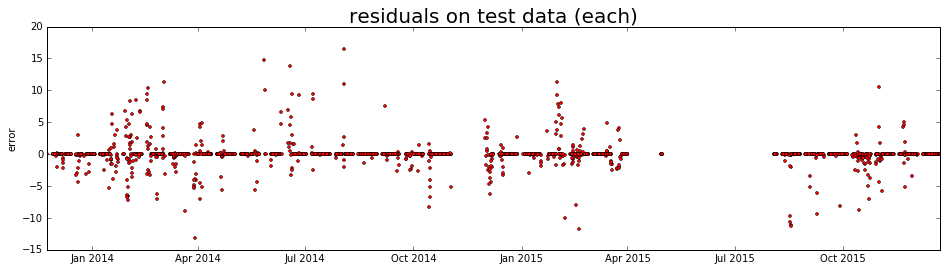

In [27]:
fig, ax = plt.subplots(figsize=(16, 4))
err = y_test - y_hat_random_forest

ax.plot_date(X_test.index, err, c='r', ms=3)
ax.set_title('residuals on test data (each)', fontsize=20)
ax.set_ylabel('error')

plt.show()

In [28]:
test = submission_format.join(microclimate_test, how='left')  # left join onto the format
test = test[microclimate_test.columns]  # now just subset back down to the input columns

assert (test.index == submission_format.index).all()

submission_format['yield'] = estimator_random_forest.predict(test)
submission_format.to_csv("./ipython_submission/random_forest_submission.csv")

<div class="alert alert-warning">
Calculate the correlations of previous time.
</div>

In [29]:
X_time = microclimate_train.copy()
y_time = labels.copy()
corrs = []
corrs_date = []

for i in xrange(36):
    offset = (i + 1) * 2
    y_pretime = labels.copy()
    y_pretime.index = y_pretime.index + pd.DateOffset(hours=offset)
    y_joint = pd.concat([y_time, y_pretime], axis=1, join='inner')
    
    corr0 = y_joint.corr().values[0][1]
    corrs_date.append(offset)
    corrs.append(corr0)

    print('corr of previous', offset, 'hours =', corr0)
    
# 2,4,6,8,18,20,22

corr of previous 2 hours = 0.824688254931
corr of previous 4 hours = 0.638191053516
corr of previous 6 hours = 0.497525338164
corr of previous 8 hours = 0.400604419135
corr of previous 10 hours = 0.343733671111
corr of previous 12 hours = 0.330901993213
corr of previous 14 hours = 0.336942307011
corr of previous 16 hours = 0.355582856495
corr of previous 18 hours = 0.385622476105
corr of previous 20 hours = 0.402832891505
corr of previous 22 hours = 0.38020304262
corr of previous 24 hours = 0.349504399482
corr of previous 26 hours = 0.311810685898
corr of previous 28 hours = 0.257207910257
corr of previous 30 hours = 0.203632374853
corr of previous 32 hours = 0.162189648448
corr of previous 34 hours = 0.128763251766
corr of previous 36 hours = 0.12044307195
corr of previous 38 hours = 0.12740905128
corr of previous 40 hours = 0.137187579759
corr of previous 42 hours = 0.139027611659
corr of previous 44 hours = 0.140706517674
corr of previous 46 hours = 0.144420566586
corr of previous 4

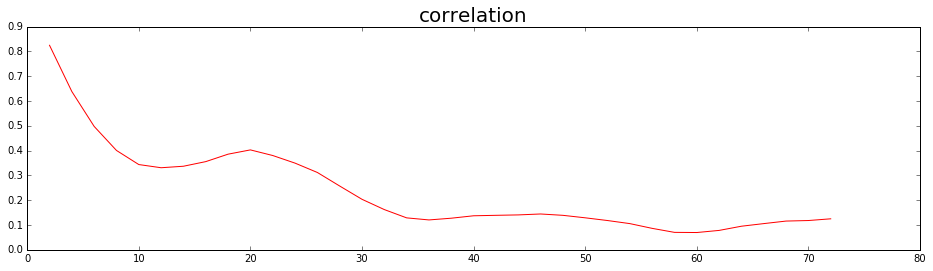

In [30]:
fig, ax = plt.subplots(figsize=(16, 4))

ax.plot(corrs_date, corrs, c='r', ms=3)
ax.set_title('correlation', fontsize=20)

plt.show()

<div class="alert alert-success">
Add previous yield features.
</div>

In [31]:
X_time = microclimate_train.copy()
y_time = labels.copy()
X_joint = microclimate_train.copy()

for i in [2,4,6,8,18,20,22]:
    offset = i
    y_pretime = labels.copy()
    y_pretime.index = y_pretime.index + pd.DateOffset(hours=offset)
    y_pretime = y_pretime.rename(columns={'yield': 'pre_yield_' + str(offset) + '_hours'})
    y_joint = pd.concat([y_time, y_pretime], axis=1, join='inner')
    X_joint = pd.concat([X_joint, y_joint], axis=1, join='outer')
    X_joint = X_joint.drop(labels='yield', axis=1)

<div class="alert alert-success">
Random Forest Regressor with pre_yield features.
</div>

In [32]:
X_train_pre_yield, X_test_pre_yield, y_train_pre_yield, y_test_pre_yield = train_test_split(X_joint,
                                                    y_time.values.ravel(),
                                                    test_size=0.3)

In [33]:
estimator_random_forest = GridSearchCV(pipe_random_forest, param_grid=params, n_jobs=-1, verbose=1)
estimator_random_forest.fit(X_train_pre_yield, y_train_pre_yield.ravel())

y_hat_pre_yield_random_forest = estimator_random_forest.predict(X_test_pre_yield)
rmse_pre_yield_random_forest = np.sqrt(mean_squared_error(y_test_pre_yield, y_hat_pre_yield_random_forest))
rmse_pre_yield_random_forest

Fitting 3 folds for each of 63 candidates, totalling 189 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:   24.5s finished


1.635852238212572

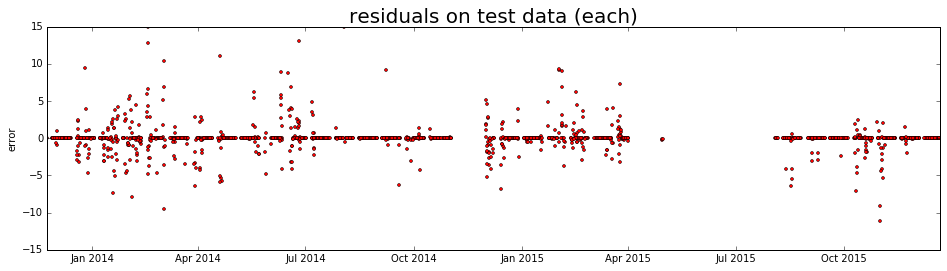

In [34]:
fig, ax = plt.subplots(figsize=(16, 4))
err = y_test_pre_yield - y_hat_pre_yield_random_forest

ax.plot_date(X_test_pre_yield.index, err, c='r', ms=3)
ax.set_title('residuals on test data (each)', fontsize=20)
ax.set_ylabel('error')

plt.show()

In [35]:
test = submission_format.join(microclimate_test, how='left')  # left join onto the format
test = test[microclimate_test.columns]  # now just subset back down to the input columns

assert (test.index == submission_format.index).all()

y_time = labels.copy()
test_joint = test.copy()

for i in [2,4,6,8,18,20,22]:
    offset = i
    y_pretime = labels.copy()
    y_pretime.index = y_pretime.index + pd.DateOffset(hours=offset)
    new_y_name = 'pre_yield_' + str(offset) + '_hours'
    y_pretime = y_pretime.rename(columns={'yield': new_y_name})
    y_joint = pd.concat([test_joint, y_pretime], axis=1, join='inner')
    test_joint = pd.concat([test_joint, y_joint[new_y_name]], axis=1, join='outer')

y_submission_pre_yield = estimator_random_forest.predict(test_joint)
submission_format['yield'] = y_submission_pre_yield
# submission_format.to_csv("./ipython_submission/pre_yield_random_forest_submission.csv")

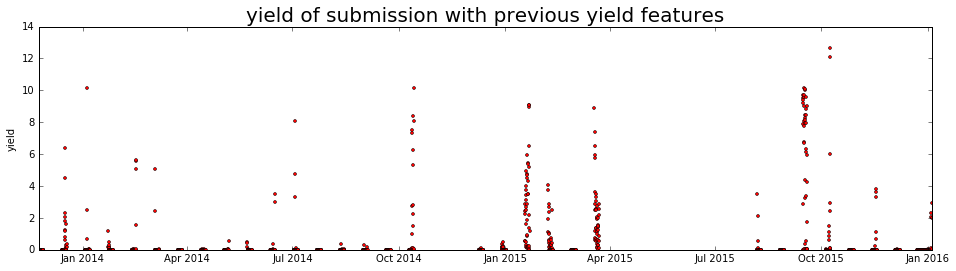

In [36]:
fig, ax = plt.subplots(figsize=(16, 4))

ax.plot_date(test_joint.index, y_submission_pre_yield, c='r', ms=3)
ax.set_title('yield of submission with previous yield features', fontsize=20)
ax.set_ylabel('yield')

plt.show()

<div class="alert alert-warning">
Remove non-related features.
</div>

In [37]:
X_time = X_joint.copy()
y_time = labels.copy()

X_with_y = pd.concat([X_time, y_time], axis=1, join='inner')

for i in xrange(13):
    print('corr of', X_with_y.columns[i], 'and yield =', X_with_y.corr().values[i][13])

corr of percip_mm and yield = -0.009742323786
corr of humidity and yield = 0.397281465772
corr of temp and yield = -0.287812639957
corr of leafwet450_min and yield = 0.392440935556
corr of leafwet460_min and yield = 0.385024345837
corr of leafwet_lwscnt and yield = 0.271091235608
corr of gusts_ms and yield = 0.191920269598
corr of wind_dir and yield = 0.027618134204
corr of wind_ms and yield = 0.176710508104
corr of pre_yield_2_hours and yield = 0.354627941835
corr of pre_yield_4_hours and yield = 0.337692282315
corr of pre_yield_6_hours and yield = 0.332732513295
corr of pre_yield_8_hours and yield = 0.346620082318


In [38]:
X_time_rm_fts = X_joint.copy()
y_time_rm_fts = labels.copy()

X_time_rm_fts = X_time_rm_fts.drop(labels='percip_mm', axis=1)
X_time_rm_fts = X_time_rm_fts.drop(labels='wind_dir', axis=1)

<div class="alert alert-success">
Random Forest Regressor with pre_yield features and removed non-related features.
</div>

In [39]:
X_train_rm_fts, X_test_rm_fts, y_train_rm_fts, y_test_rm_fts = train_test_split(X_time_rm_fts,
                                                    y_time.values.ravel(),
                                                    test_size=0.3)

In [40]:
estimator_random_forest = GridSearchCV(pipe_random_forest, param_grid=params, n_jobs=-1, verbose=1)
estimator_random_forest.fit(X_train_rm_fts, y_train_rm_fts.ravel())

y_hat_rm_fts_random_forest = estimator_random_forest.predict(X_test_rm_fts)
rmse_rm_fts_random_forest = np.sqrt(mean_squared_error(y_test_rm_fts, y_hat_rm_fts_random_forest))
rmse_rm_fts_random_forest

Fitting 3 folds for each of 63 candidates, totalling 189 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:   23.2s finished


1.8950905907331645

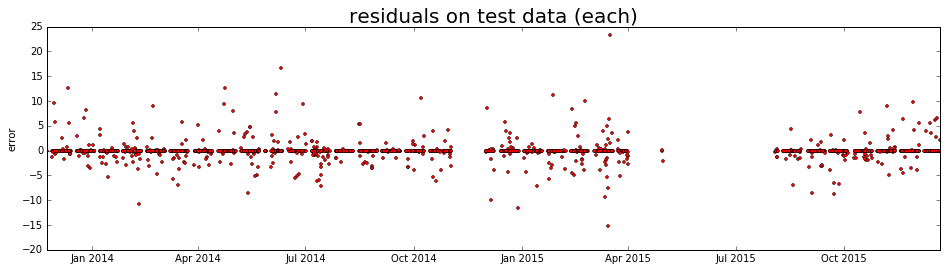

In [41]:
fig, ax = plt.subplots(figsize=(16, 4))
err = y_test_rm_fts - y_hat_rm_fts_random_forest

ax.plot_date(X_test_pre_yield.index, err, c='r', ms=3)
ax.set_title('residuals on test data (each)', fontsize=20)
ax.set_ylabel('error')

plt.show()

<div class="alert alert-danger">
===========NEW START===========
</div>

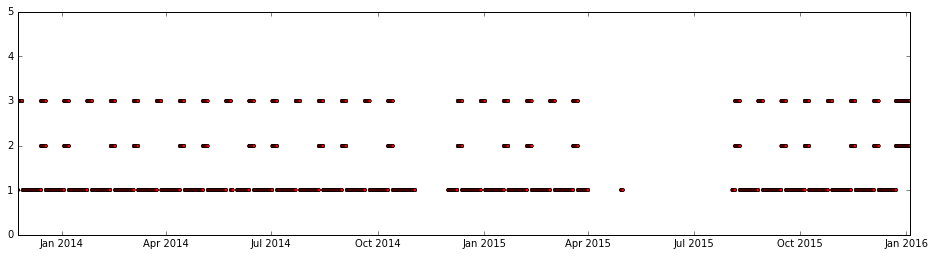

In [42]:
X_time = microclimate_train.copy()
y_time = labels.copy()

X_test_time = microclimate_test.copy()
y_test_time = submission_format.copy()

fig, ax = plt.subplots(figsize=(16, 4))

ax.plot_date(X_time.index, [1 for i in xrange(y_time.shape[0])], c='r', ms=3)
ax.plot_date(X_test_time.index, [2 for i in xrange(X_test_time.shape[0])], c='r', ms=3)
ax.plot_date(y_test_time.index, [3 for i in xrange(y_test_time.shape[0])], c='r', ms=3)
ax.set_ylim([0, 5])

plt.show()

In [43]:
X_time = microclimate_train.copy()
y_time = labels.copy()

X_test_time = microclimate_test.copy()
y_test_time = submission_format.copy()

y_all_time = pd.concat([X_test_time, y_test_time.drop(labels='yield', axis=1)], axis=1, join='outer')
all_time = pd.concat([X_time, y_all_time], axis=0, join='outer')

X_joint = all_time.copy()

# Impute previous yield.
# for i in [2,4,6,8,18,20,22]:
for i in [2]:
    offset = i
    y_pretime = labels.copy()
    y_pretime.index = y_pretime.index + pd.DateOffset(hours=offset)
    
    y_pretime = y_pretime.rename(columns={'yield': 'pre_yield_' + str(offset) + '_hours'})
    y_joint = pd.concat([y_time, y_pretime], axis=1, join='outer')
    
    X_joint_index = pd.DataFrame(index=X_joint.index)
    X_joint_tmp = pd.concat([X_joint_index, y_joint], axis=1, join='inner')
    X_joint = pd.concat([X_joint, X_joint_tmp], axis=1, join='outer')
    X_joint = X_joint.drop(labels='yield', axis=1)
    
# X_y = pd.concat([X_joint, y_time], axis=1, join='inner')
# for i in xrange(9, 16):
#     print(X_y.corr().values[i][16])
# X_y.describe()

<div class="alert alert-danger">
No imputation perceptron.
</div>

In [44]:
X_joint_train_all = X_joint.loc[X_time.index]
y_train_all = labels.copy()

# imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
# fixed_X_train = X_joint_train_all.values
# imp.fit(fixed_X_train)
# fixed_X_train = imp.transform(fixed_X_train)
# normalize(fixed_X_train, copy=False)

steps_random_forest = [('imputer', Imputer()),
         ('pca', PCA()),
         ('rf', ensemble.RandomForestRegressor())]
pipe_random_forest = Pipeline(steps_random_forest)

# create the grid search
params = {
    'pca__n_components': range(2, X_train.shape[1]),
    'imputer__strategy': ['mean', 'median', 'most_frequent']
}

estimator_random_forest = GridSearchCV(pipe_random_forest, param_grid=params, n_jobs=-1, verbose=1)
estimator_random_forest.fit(X_joint_train_all, y_train_all.values.ravel())

# y_hat_new = estimator_random_forest.predict(X_test_pre_yield)
# rmse_pre_yield_random_forest = np.sqrt(mean_squared_error(y_test_new, y_hat_new))
# rmse_pre_yield_random_forest

Fitting 3 folds for each of 21 candidates, totalling 63 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:   11.0s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('pca', PCA(copy=True, n_components=None, whiten=False)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=...imators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'imputer__strategy': ['mean', 'median', 'most_frequent'], 'pca__n_components': [2, 3, 4, 5, 6, 7, 8]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [45]:
X_joint_new = X_joint.drop(labels=X_joint.index[0:52], axis=0).copy()
y_test_all = submission_format.copy()
y_good = pd.read_csv('Cross Validation + Bagging Classifier + Bagging Regressor Submission.csv',
                     index_col=0, parse_dates=[0])
y_good1 = pd.read_csv('ipython_submission/09_perceptron_random_forest_submission(3.8688).csv',
                     index_col=0, parse_dates=[0])

for timeindex in X_joint_new.index:
    if timeindex not in X_time.index:
        if X_joint_new.loc[timeindex][9:].isnull().sum(axis=0) > 0 or timeindex not in X_test_time.index:
            y_test_all.loc[timeindex, 'yield'] = 0
            continue

        y_hat_test = estimator_random_forest.predict(X_joint_new.loc[timeindex])
        if y_hat_test[0] < 0.01:
            y_hat_test[0] = 0
        y_test_all.loc[timeindex, 'yield'] = y_hat_test[0]
#         for i in [2,4,6,8,18,20,22]:
        for i in [2]:
            offset = i
            pre_time = timeindex + pd.DateOffset(hours=offset)
#             X_joint_new.loc[pre_time, 'pre_yield_' + str(offset) + '_hours'] = y_hat_test[0]
            if y_good.loc[timeindex]['yield'] == 0:
                y_plus = y_good.loc[timeindex]['yield']
            else:
                y_plus = (y_good.loc[timeindex]['yield'] + y_good1.loc[timeindex]['yield']) / 6
            X_joint_new.loc[pre_time, 'pre_yield_' + str(offset) + '_hours'] = y_plus

/Users/Shauro/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/Shauro/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/Shauro/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

In [46]:
y_submission_perceptron = y_test_all.copy()
submission_format_new = submission_format.copy()
submission_format_new['yield'] = y_submission_perceptron
submission_format_new.to_csv("./ipython_submission/13_perceptron_random_forest_submission.csv")

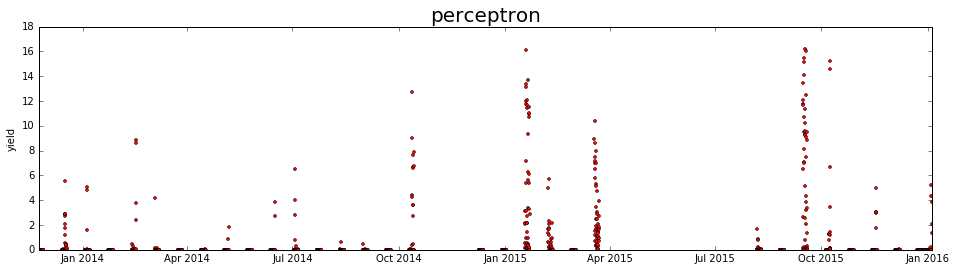

In [47]:
fig, ax = plt.subplots(figsize=(16, 4))

ax.plot_date(y_test_all.index, y_test_all, c='r', ms=3)
ax.set_title('perceptron', fontsize=20)
ax.set_ylabel('yield')

plt.show()

In [ ]:
X_joint_new.head(n=20)

,percip_mm,humidity,temp,leafwet450_min,leafwet460_min,leafwet_lwscnt,gusts_ms,wind_dir,wind_ms,pre_yield_2_hours
2013-11-28 00:00:00,0.000000,0.419516,8.183334,0,0,440.000000,3.382230,125.250000,3.030176,NaN
2013-11-28 02:00:00,0.000000,0.422065,8.120834,0,0,440.000000,3.482816,124.500000,3.155909,0.000000
2013-11-28 04:00:00,0.000000,0.369994,8.562500,0,0,439.291667,3.403185,124.333333,3.084661,0.000000
2013-11-28 06:00:00,0.000000,0.382980,8.391667,0,0,439.000000,3.336127,126.916667,3.055323,0.000000
2013-11-28 08:00:00,0.000000,0.377310,9.158333,0,0,439.000000,3.927075,120.916667,3.629505,0.000000
2013-11-28 10:00:00,0.000000,0.347650,10.979167,0,0,438.791667,3.910310,121.583333,3.533110,0.000000
2013-11-28 12:00:00,0.000000,0.338138,12.700000,0,0,438.625000,3.281643,125.416667,2.858340,0.069677
2013-11-28 14:00:00,0.000000,0.337489,13.345833,0,0,438.916667,2.950545,127.958333,2.594300,0.097547
2013-11-28 16:00:00,0.000000,0.353224,13.091667,0,0,439.000000,2.447611,134.000000,2.170998,0.000000
2013-11-28 18:00:00,0.000000,0.357423,12.183333,0,0,439.000000,3.042749,123.125000,2.707460,0.000000


<div class="alert alert-danger">
For first submission interval:<br>
1. all 0 √<br>
2. take ave<br>
3. impute features for missing interval
</div>

In [ ]:
X_joint_from28 = X_joint.drop(labels=X_joint.index[0:4], axis=0)
X_joint_from28

,percip_mm,humidity,temp,leafwet450_min,leafwet460_min,leafwet_lwscnt,gusts_ms,wind_dir,wind_ms,pre_yield_2_hours
2013-11-24 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2013-11-24 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-11-24 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-11-24 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-11-24 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-11-24 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-11-24 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-11-24 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-11-24 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-11-24 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
ft_im = X_joint_from28['temp']
nan_num = ft_im.isnull().sum(axis=0)
nan_num

497

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4))

ax.plot_date(ft_im.index, ft_im, c='r', ms=3)
ax.set_title('temp', fontsize=20)

plt.show()

In [ ]:
ft_im_validation = ft_im.sample(n=750).dropna()
ft_im_impute = ft_im_validation.copy()

for i in xrange(ft_im_impute.shape[0]):
    timeindex = ft_im_impute.index[i]
    time_pre = timeindex - pd.DateOffset(hours=2)
    time_late = timeindex + pd.DateOffset(hours=2)
    
    if time_pre in ft_im.index and time_late in ft_im.index:
        ft_pre = ft_im[time_pre]
        ft_late = ft_im[time_late]
        if not np.isnan(ft_pre) and not np.isnan(ft_late):
            ft_im_impute[timeindex] = (ft_pre + ft_late) / 2
        else:
            ft_im_impute[timeindex] = float('nan')
    else:
        ft_im_impute[timeindex] = float('nan')
print(ft_im_impute.isnull().sum(axis=0))

ft_im_impute